In [1]:
# https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as tf
from os import walk
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image
from torchvision import transforms
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

In [2]:
train_df = pd.read_csv('train_df2.csv')
test_df = pd.read_csv('test_df2.csv')

In [3]:
train_df.sample(10)

,Finding Label,Image Index,h,w,x,y
63171,1,00019621_000.png,2544.0,3056.0,0.139000,0.139000
39637,1,00012219_012.png,2048.0,2500.0,0.168000,0.168000
38485,1,00011896_007.png,2048.0,2500.0,0.168000,0.168000
47887,1,00014754_000.png,2500.0,2048.0,0.168000,0.168000
40826,13,00012620_002.png,2991.0,2992.0,0.143000,0.143000
60642,12,00018778_004.png,1677.0,2122.0,0.143000,0.143000
81350,1,00027415_042.png,2544.0,3056.0,0.139000,0.139000
82543,1,00027912_008.png,2021.0,2021.0,0.194311,0.194311
54046,1,00016796_002.png,2048.0,2500.0,0.168000,0.168000
12368,8,00003867_011.png,2048.0,2500.0,0.168000,0.168000


In [4]:
# (train_df['Image Index'] == '00030181_001.png').value_counts()
# 00028247_001.png

In [5]:
import os
filename_list = []
for root, dirs, files in os.walk("../Datasets/Lungs_Dataset/Xray", topdown=True):
    for name in files:
        filename_list.append(name)
#         with Image.open(os.path.join("datasets/data/images", name)) as f:
#             print(len(f.size))

In [6]:
train_df['Image Index'].isin(filename_list).value_counts()

True    86524
Name: Image Index, dtype: int64

In [7]:
train_df = train_df[train_df['Image Index'].isin(filename_list)]

In [8]:
train_df['Image Index'].isin(filename_list).value_counts()

True    86524
Name: Image Index, dtype: int64

In [9]:
train_df['Image Index'].isna().value_counts()

False    86524
Name: Image Index, dtype: int64

In [10]:
test_df = test_df[test_df['Image Index'].isin(filename_list)]

In [11]:
test_df.sample(10)

,Finding Label,Image Index,h,w,x,y
18979,8,00022416_001.png,2991.0,2992.0,0.143000,0.143000
15353,0,00018233_054.png,2544.0,3056.0,0.139000,0.139000
10929,4,00014083_002.png,2048.0,2500.0,0.168000,0.168000
7339,12,00011237_060.png,2048.0,2500.0,0.168000,0.168000
23593,1,00029316_000.png,2021.0,2021.0,0.194311,0.194311
24179,1,00029809_003.png,3056.0,2544.0,0.139000,0.139000
19818,4,00023156_004.png,3056.0,2544.0,0.139000,0.139000
5057,1,00008295_039.png,2991.0,2678.0,0.143000,0.143000
1530,9,00002176_008.png,2991.0,2890.0,0.143000,0.143000
25245,1,00030480_000.png,2021.0,2021.0,0.194311,0.194311


In [12]:
class RescaleImage(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
            
        The samples coming into this class will have its images reduced assuming
        the input is a h, w, c numpy array
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        h, w = image.size

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = image.resize((new_h, new_w))

        return {'image': img, 'label': label}

In [105]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = np.array(image)
        if len(image.shape) > 2:
            image = image.convert('LA')
        # numpy image: H x W x C
        # torch image: C X H X W
#         return {'image': torch.from_numpy(image).unsqueeze(0),
        return {'image': torch.from_numpy(image),                
                'label': torch.from_numpy(label)}

In [106]:
#  print([Image.open('../Datasets/Lungs_Dataset/Xray/'+train_df['Image Index'][each_import]).size for each_import in range(100)])

In [107]:
#Note this will return an Image object, of h and w, and its corresponding label
class CovidLungsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe['Image Index'][idx])
        my_image = Image.open(img_name)        
        if len(my_image.size) > 2:
            assert len(my_image.size) > 2
        row = self.dataframe.iloc[idx]
        label = np.array([row['Finding Label']])
        sample = {'image': my_image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [108]:
my_train_set = CovidLungsDataset(train_df, '../Datasets/Lungs_Dataset/Xray', transform=transforms.Compose([
        RescaleImage(200),
#         ToTensor()
]))

(PIL.Image.Image, (200, 200))

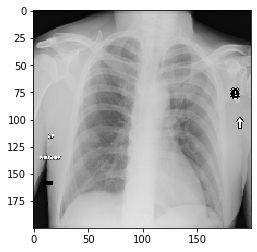

In [112]:
'''The original data coming out of the Dataset is a dictionary, 
the image is an Image object with the corresponding label.
The size of all of these images are 1024 by 1024.
The RescaleImage will convert the Image object to an Image object with 200x200 in size, 
leaving the label alone.
The ToTensor will convert the Image object with 200x200 to tensors of 1x200x200'''
my_image = my_train_set.__getitem__(4)['image']
#imshow will work if it's h,w,c or h,w
#torch is c,h,w
#line below can be used if you don't use ToTensor
plt.imshow(my_image)
type(my_image), my_image.size

In [ ]:
# plt.imshow(my_image.squeeze(0));

In [113]:
batch_loader_params = {
    "batch_size": 5,
    "shuffle": True,
    "num_workers": 2
}
dataloader = DataLoader(my_train_set, **batch_loader_params)

In [114]:
iter(dataloader).next()
for i, each in enumerate(iter(dataloader)):
    print(type(each))

BrokenPipeError: [Errno 32] Broken pipe

In [70]:
# batch_samples = iter(dataloader)
# samples = batch_samples.next()
# datset_batch = torchvision.utils.make_grid(samples['image'])

In [71]:
# plt.figure(figsize=(20,10))
# for index, each in enumerate(datset_batch):
#     plt.imshow(each.squeeze(0))

In [72]:
# 1x200x200

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)  # 28x28x4 with batch of 6, 18816
#         self.conv2 = nn.Conv2d(20, 50, 5, 1)
#         self.fc1 = nn.Linear(4*4*50, 60)
#         self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 24x24x20 with at batch of 6
        return x

In [73]:
net = Net()

In [74]:
def spatial_size(input_size: int, kernel_size: int, stride: int = 1, padding: int = 0):
    # https://cs231n.github.io/convolutional-networks/
    spatial_size = (input_size - kernel_size + 2 * padding)/stride + 1
    assert spatial_size % 1 == 0
    assert spatial_size > 0
    return int(spatial_size)

In [75]:
print(spatial_size(1024, 500))

525


In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [77]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 525, 1)  
        self.conv2 = nn.Conv2d(100, 50, 50, 1)
        self.fc1 = nn.Linear(4*4*50, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2, 2) 
#         x = F.relu(self.conv2(x)) 
#         x = F.max_pool2d(x, 2, 2) 
#         x = x.view(-1, 4*4*50)    
#         x = F.relu(self.fc1(x))   
#         x = self.fc2(x)           
        # # There's no activation at the final layer because of the criterion of CEL
        return x


net = Net()

In [78]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data['image'], data['label']
        print(data['image'].shape)
        x, y = data['label'], data['image']

#         # zero the parameter gradients
#         optimizer.zero_grad()
#         # forward + backward + optimize
#         outputs = net(data['image'])
#         loss = criterion(outputs, data['label'].squeeze())
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()

#     print('[%d, %5d] loss: %.5f' %
#           (epoch + 1, i + 1, running_loss / (epoch*i+1)))

BrokenPipeError: [Errno 32] Broken pipe